# Battle of the Neighbourhoods

### Content

* [Sect A](#a): Problem statement
* [Sect B](#b): Data
* [Sect C](#c): Scrape data from HTML table into a DataFrame using read_html
* [Sect D](#d): Furnish with Geographical Coordinates
* [Sect E](#e): Map of Kyoto and Wards
* [Sect E](#e1): Troubleshooting the Map
* [Sect F](#f): Explore the First Neighbourhood in Kyoto
* [Sect G](#g): Explore the Neighbourhoods in Kyoto
* [Sect H](#h): Analyze Each Neighborhood
* [Sect I](#i): Cluster Neighborhoods
* [Sect J](#j): Examine the Clusters
* [Sect K](#k): Recommendations

<a id='a'></a>
### Problem statement: 

<p><b>What can be done to determine the Client’s business positioning and potential restaurant locations in Kyoto?</b>

Along the line of Business Strategies, it was decided that Unsupervised Machine Learning technique could be applied to analysis and uncover insights valuable to influencing the formulation of Client’s business strategies.
Specifically, K-Means clustering will be applied onto the relevant restaurants’ geo spatial data to cluster these entities and uncover insights such as viable restaurant themes and suitable restaurant locations.  
</p>

<a id='b'></a>
### Data

<p>Two data sources were identified for use. These are:

1) List of Kyoto wards and their respective geo coordinates. The wards list can be retrieved from the following webpage ( https://en.wikipedia.org/wiki/Wards_of_Kyoto), whereas the coordinates can be retrieved using the geopy library.

2) Restaurants in each neighborhood of Kyoto. The data can be retrieved using the Foursquare API, and specifying the particular category of interest. 
</p>

In [4]:
# Import libraries
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim 
import folium
import requests
import json

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

<a id='c'></a>
### Scrape data from HTML table into a DataFrame using read_html

The relevant data resides in one of the table on the stated wikipedia url. Use pd.read_html() to retrieve the data.

In [5]:
# wards of kyoto url
ward_url = 'https://en.wikipedia.org/wiki/Wards_of_Kyoto'

In [6]:
# More concise method than requests and Beautiful soup
dataframe_list = pd.read_html(ward_url, flavor='bs4')
df_raw = dataframe_list[1]
df_raw

Name Population Density (/km²) Area (km²) % of total  \
              Name Population Density (/km²) Area (km²) % of total   
0       Fushimi-ku     280655           4552      61.66       7.4%   
1   Higashiyama-ku      39044           5220       7.48       0.9%   
2       Kamigyō-ku      85113          12107       7.03       0.8%   
3          Kita-ku     119474           1259      94.88      11.5%   
4        Minami-ku      99927           6320      15.81       1.9%   
5       Nakagyō-ku     109341          14756       7.41       0.9%   
6      Nishikyō-ku     150962           2548      59.24       7.2%   
7         Sakyō-ku     168266            682     246.77      29.8%   
8      Shimogyō-ku      82668          12193       6.78       0.8%   
9          Ukyō-ku     204262            699     292.07      35.3%   
10    Yamashina-ku     135471           4720      28.70       3.5%   
11           Total    1475183           1782     827.83     100.0%   

   Forest Area (km²) Forest Cover Inhabitable Area                 
   Forest Area (km²) Forest Cover            (km²) Density (/km²)  
0              14.58        23.6%            47.12           5956  
1               1.58        21.1%             5.90           6618  
2               0.00         0.0%             7.03          12107  
3              78.85        83.1%            16.02           7458  
4               0.00         0.0%            15.81           6320  
5               0.00         0.0%             7.41          14756  
6              32.53        54.9%            26.82           5629  
7             215.26        87.2%            31.55           5333  
8               0.00         0.0%             6.78          12193  
9             253.77        86.9%            38.29           5335  
10             13.64        47.5%            15.40           8797  
11            610.21        73.7%           218.13           6763

In [7]:
# Data processing - refine and get relevant data
df_raw.columns = df_raw.columns.get_level_values(1)

In [8]:
df_raw

,Name,Population,Density (/km²),Area (km²),% of total,Forest Area (km²),Forest Cover,(km²),Density (/km²)
0,Fushimi-ku,280655,4552,61.66,7.4%,14.58,23.6%,47.12,5956
1,Higashiyama-ku,39044,5220,7.48,0.9%,1.58,21.1%,5.90,6618
2,Kamigyō-ku,85113,12107,7.03,0.8%,0.00,0.0%,7.03,12107
3,Kita-ku,119474,1259,94.88,11.5%,78.85,83.1%,16.02,7458
4,Minami-ku,99927,6320,15.81,1.9%,0.00,0.0%,15.81,6320
5,Nakagyō-ku,109341,14756,7.41,0.9%,0.00,0.0%,7.41,14756
6,Nishikyō-ku,150962,2548,59.24,7.2%,32.53,54.9%,26.82,5629
7,Sakyō-ku,168266,682,246.77,29.8%,215.26,87.2%,31.55,5333
8,Shimogyō-ku,82668,12193,6.78,0.8%,0.00,0.0%,6.78,12193
9,Ukyō-ku,204262,699,292.07,35.3%,253.77,86.9%,38.29,5335


In [9]:
df_ward  = df_raw.iloc[: , :4]
df_ward.drop(index=11, inplace=True)
df_ward.tail(1)

,Name,Population,Density (/km²),Area (km²)
10,Yamashina-ku,135471,4720,28.7


In [10]:
# Check data types
df_ward.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            11 non-null     object 
 1   Population      11 non-null     int64  
 2   Density (/km²)  11 non-null     int64  
 3   Area (km²)      11 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 440.0+ bytes


In [11]:
print(f"df_ward has {df_ward.shape[0]} rows, {df_ward.shape[1]} columns")

df_ward has 11 rows, 4 columns


<a id='d'></a>
### Furnish with Geographical Coordinates 

<p>geopy is a Python client that facilitates the identification of the coordinates of addresses, cities, countries, and landmarks through third-party geocoders and other data sources. Use geopy to get the latitude and longitude of Kyoto.
</p>

In [12]:
# Define and name user_Agent as "Kyoto_wards".  
geolocator = Nominatim(user_agent="Kyoto_wards")

In [13]:
# Get the coordinates per ward name
df_ward['Name'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))

0     (34.9535921, 135.7680447)
1     (34.9985608, 135.7808951)
2     (35.0257221, 135.7453647)
3       (35.755838, 139.736687)
4     (35.0887632, 136.9266427)
5     (35.0076892, 135.7470707)
6      (34.981741, 135.7008828)
7      (35.0385567, 135.780494)
8     (34.9925269, 135.7350963)
9      (35.0015936, 135.724014)
10    (34.9809453, 135.8081872)
Name: Name, dtype: object

In [14]:
df_ward['Coord']= df_ward['Name'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df_ward.head(1)

,Name,Population,Density (/km²),Area (km²),Coord
0,Fushimi-ku,280655,4552,61.66,"(34.9535921, 135.7680447)"


In [15]:
# Split the coordinates into Lat and Long, drop the M
df_ward[['Latitude', 'Longitude']] = df_ward['Coord'].apply(pd.Series)
# drop the Coord column
df_ward.drop(['Coord'], axis=1, inplace=True)

df_ward.tail(1)

,Name,Population,Density (/km²),Area (km²),Latitude,Longitude
10,Yamashina-ku,135471,4720,28.7,34.980945,135.808187


In [16]:
# Summary check on the datatypes, and null values
df_ward.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            11 non-null     object 
 1   Population      11 non-null     int64  
 2   Density (/km²)  11 non-null     int64  
 3   Area (km²)      11 non-null     float64
 4   Latitude        11 non-null     float64
 5   Longitude       11 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 616.0+ bytes


<a id='e'></a>
### Map of Kyoto and Wards

<p>Get the coordinates of kyoto, create a map with the neighbourhoods (i.e. wards) superimposed on the map.</p>

In [17]:
# Identify coordinates of Tokyo, define and name user_agent as "Kyoto_explorer"
place = 'Kyoto'
geolocator = Nominatim(user_agent="Kyoto_explorer")
location = geolocator.geocode(place)
kyoto_lat = location.latitude
kyoto_lon = location.longitude
print(f"Coordinates of {place} are {kyoto_lat}, {kyoto_lon}")

Coordinates of Kyoto are 35.021041, 135.7556075


In [18]:
# Visualize the neighbourhoods
map_kyoto = folium.Map(location = [kyoto_lat, kyoto_lon], zoom_start = 12)

# Add markers
for lat, lng, label in zip(df_ward['Latitude'], df_ward['Longitude'], df_ward['Name']):
    folium.RegularPolygonMarker([lat, lng],
                                popup=label,
                                radius=5,
                                color='purple',
                                fill_color='blue',
                                fill_opacity=0.7).add_to(map_kyoto) 
# display map
map_kyoto

<a id='e1'></a>
### Troubleshooting the Map

It appears that there are only 9 wards of the 11 wards plotted on the map! A possible hypothesis is that some of the coordinates of the wards returned could be those in other cities of Japan. A detailed review reveals that 'Kita-Ku' and 'Minami-ku' of Kyoto are not plotted on the Kyoto Map.

First check the returned addresses for these two wards, then find the correct coordinates. Finally replace the coordinates in the dataframe.

In [19]:
# Summary of the coordinates and wards
for lat, lng, label in zip(df_ward['Latitude'], df_ward['Longitude'], df_ward['Name']):
    print(lat,lng, label)

34.9535921 135.7680447 Fushimi-ku
34.9985608 135.7808951 Higashiyama-ku
35.0257221 135.7453647 Kamigyō-ku
35.755838 139.736687 Kita-ku
35.0887632 136.9266427 Minami-ku
35.0076892 135.7470707 Nakagyō-ku
34.981741 135.7008828 Nishikyō-ku
35.0385567 135.780494 Sakyō-ku
34.9925269 135.7350963 Shimogyō-ku
35.0015936 135.724014 Ukyō-ku
34.9809453 135.8081872 Yamashina-ku


In [20]:
# Get the addresses for Kita-ku & Minami-ku
loc_kita = geolocator.geocode("Kita-ku")
loc_minami = geolocator.geocode("Minami-ku")
print(f"returned address of Kita-ku: {loc_kita.address}")
print(f"returned address of Minami-ku: {loc_minami.address}")

returned address of Kita-ku: 北区, 東京都, 日本
returned address of Minami-ku: 南区, 名古屋市, 愛知県, 日本


In [21]:
# Get the actual address of the kyoto wards
loc_kita_kyo = geolocator.geocode("Kita-ku, Kyoto")
loc_minami_kyo = geolocator.geocode("Minami-ku, Kyoto")
print(f"returned address of Kita-ku: {loc_kita_kyo.address}")
print(f"returned address of Minami-ku: {loc_minami_kyo.address}")

returned address of Kita-ku: 北区, 京都市, 京都府, 日本
returned address of Minami-ku: 南区, 京都市, 京都府, 日本


Confirming the correct addresses have been acquired, review the coordinates.

In [22]:
kita_kyo_lat = loc_kita_kyo.latitude
kita_kyo_lon = loc_kita_kyo.longitude
minami_kyo_lat = loc_minami_kyo.latitude
minami_kyo_lon = loc_minami_kyo.longitude
print(f"corrected coordinates of Kita-ku, Kyoto: {kita_kyo_lat}, {kita_kyo_lon}")
print(f"corrected coordinates of Minami-ku, Kyoto: {minami_kyo_lat}, {minami_kyo_lon}")

corrected coordinates of Kita-ku, Kyoto: 35.0519284, 135.7499268
corrected coordinates of Minami-ku, Kyoto: 34.9637985, 135.736383


In [23]:
# Before coordinates replace
df_ward.loc[4]

Name              Minami-ku
Population            99927
Density (/km²)         6320
Area (km²)            15.81
Latitude            35.0888
Longitude           136.927
Name: 4, dtype: object

In [24]:
# Update the coordinates in dataframe
df_ward.loc[3,'Latitude'] = kita_kyo_lat
df_ward.loc[3,'Longitude'] = kita_kyo_lon
df_ward.loc[4,'Latitude'] = minami_kyo_lat
df_ward.loc[4,'Longitude'] = minami_kyo_lon

In [25]:
# After coordinates replace
df_ward.loc[4]

Name              Minami-ku
Population            99927
Density (/km²)         6320
Area (km²)            15.81
Latitude            34.9638
Longitude           135.736
Name: 4, dtype: object

In [26]:
# Replotting the map, 11 wards expected
map_kyoto = folium.Map(location = [kyoto_lat, kyoto_lon], zoom_start = 12)

# Add markers
for lat, lng, label in zip(df_ward['Latitude'], df_ward['Longitude'], df_ward['Name']):
    folium.RegularPolygonMarker([lat, lng],
                                popup=label,
                                radius=5,
                                color='purple',
                                fill_color='blue',
                                fill_opacity=0.7).add_to(map_kyoto) 
# display map
map_kyoto

<a id='f'></a>
### Explore the First Neighbourhood in Kyoto

#### Define Foursquare Credentials and Version

In [67]:
# Remember to remove prior to release
CLIENT_ID = ''
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210624' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Explore the first neighborhood in our dataframe.

In [35]:
# Name of first Kyoto ward in dataframe
nb_name = df_ward.loc[0,'Name'] 
print(f"First ward in Kyoto wards dataframe: {nb_name}")

First ward in Kyoto wards dataframe: Fushimi-ku


In [36]:
# Get this neighbourhood's lat and lon
nb_lat = df_ward.loc[0, 'Latitude'] 
nb_lon = df_ward.loc[0, 'Longitude'] 
nb_name = df_ward.loc[0,'Name'] 

print(f"{nb_name}'s latitude and longitude: {nb_lat} & {nb_lon}.")

Fushimi-ku's latitude and longitude: 34.9535921 & 135.7680447.


#### get the top 100 venues that are within a radius of 500 meters of the neighbourhood

In [68]:
# Create the url
limit = 100
radius = 500
url = url='http://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                       CLIENT_SECRET,
                                                                                                                       VERSION,
                                                                                                                       nb_lat,
                                                                                                                       nb_lon,
                                                                                                                       radius,
                                                                                                                       limit)

# check url
url

'http://api.foursquare.com/v2/venues/explore?client_id=&client_secret=&v=20210624&ll=34.9535921,135.7680447&radius=500&limit=100'

In [ ]:
# send the GET request and review the results
results = requests.get(url).json()
results

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean column headers
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,京都市青少年科学センター,Science Museum,34.955775,135.766758
1,ダイソー 京阪藤森駅前店,Discount Store,34.957054,135.769591
2,7-Eleven (セブンイレブン 深草直違橋店),Convenience Store,34.954810,135.771474
3,FamilyMart (ファミリーマート 京阪藤森駅前店),Convenience Store,34.956988,135.770034
4,7-Eleven (セブンイレブン 深草西浦5丁目店),Convenience Store,34.957735,135.767783


In [41]:
# Number of venues returned by Foursquare
print(f"number of venues returned via Foursquare API: {nearby_venues.shape[0]}")

number of venues returned via Foursquare API: 25


In [42]:
# Number of unique categories in the neighbourhood
print(f"number of unique venue categories: {len(nearby_venues['categories'].unique())}")

number of unique venue categories: 15


In [43]:
# venues by category count
nearby_venues['categories'].value_counts()

Convenience Store    5
Bakery               3
Intersection         2
Park                 2
Bus Stop             2
Café                 2
Food & Drink Shop    1
Discount Store       1
Shopping Mall        1
Ramen Restaurant     1
History Museum       1
Train Station        1
Science Museum       1
Bath House           1
Supermarket          1
Name: categories, dtype: int64

<a id='g'></a>
### Explore the Neighbourhoods in Kyoto

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
kyoto_venues = getNearbyVenues(names=df_ward['Name'],
                               latitudes=df_ward['Latitude'],
                               longitudes=df_ward['Longitude'])

Fushimi-ku
Higashiyama-ku
Kamigyō-ku
Kita-ku
Minami-ku
Nakagyō-ku
Nishikyō-ku
Sakyō-ku
Shimogyō-ku
Ukyō-ku
Yamashina-ku


In [46]:
kyoto_venues_restr = kyoto_venues[kyoto_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
# set index to start from 1
kyoto_venues_restr.index = np.arange(1, len(kyoto_venues_restr)+1)
kyoto_venues_restr.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Fushimi-ku,34.953592,135.768045,頑固麺,34.957260,135.765179,Ramen Restaurant
2,Higashiyama-ku,34.998561,135.780895,清水庵 よしむら,34.996493,135.780458,Japanese Restaurant
3,Higashiyama-ku,34.998561,135.780895,Kikunoi (菊乃井 本店),35.001889,135.781785,Japanese Restaurant
4,Higashiyama-ku,34.998561,135.780895,阿古屋茶屋,34.998094,135.780900,Japanese Restaurant
5,Higashiyama-ku,34.998561,135.780895,Kamanza (釜座 清水二年坂店),34.998836,135.780755,Japanese Restaurant


In [47]:
print(f"Types of restaurants in kyoto: {len(kyoto_venues_restr['Venue Category'].unique())}")

Types of restaurants in kyoto: 22


In [48]:
# create a dataframe with the venue category and counts
df_counts = kyoto_venues_restr['Venue Category'].value_counts().to_frame(name='counts')
df_counts = df_counts.reset_index()
df_counts.rename(index=str, columns={"index": "venue_category"}, inplace=True)

In [49]:
df_counts

,venue_category,counts
0,Ramen Restaurant,16
1,Japanese Restaurant,16
2,Donburi Restaurant,8
3,Chinese Restaurant,6
4,Fast Food Restaurant,4
5,Sushi Restaurant,4
6,Restaurant,4
7,Okonomiyaki Restaurant,4
8,Italian Restaurant,3
9,Yakitori Restaurant,2


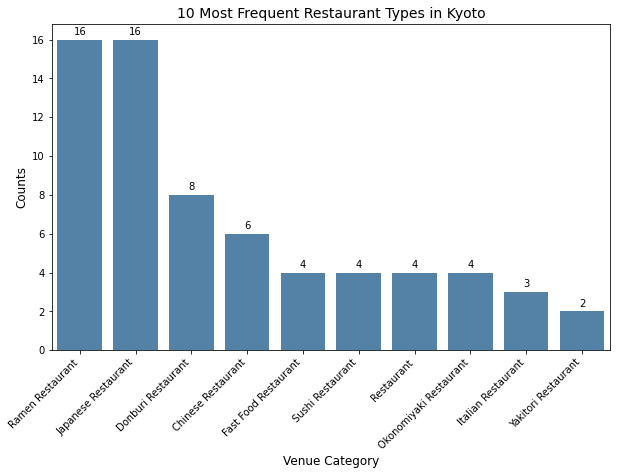

In [50]:
fig = plt.figure(figsize=(10,6))
fig = sns.barplot(x='venue_category',y='counts',data=df_counts[0:10],color='steelblue')
plt.title('10 Most Frequent Restaurant Types in Kyoto', fontsize=14)
plt.xlabel("Venue Category", fontsize=12)
plt.ylabel ("Counts", fontsize=12)
plt.xticks(rotation=45,  horizontalalignment='right')

for bar in fig.patches:
    # passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    fig.annotate(format(bar.get_height(), '.0f'), 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', 
                 va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.savefig("10 Most Frequent Restaurant Types in Kyoto.png")

plt.show()

Check how many restuarants returned for each neighborhood (Kyoto ward).


In [51]:
kyoto_venues_restr.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count()).sort_values()

Neighborhood
Fushimi-ku         1
Kita-ku            2
Minami-ku          2
Yamashina-ku       6
Kamigyō-ku         8
Nishikyō-ku        9
Shimogyō-ku        9
Nakagyō-ku        10
Sakyō-ku          10
Ukyō-ku           10
Higashiyama-ku    14
Name: Venue Category, dtype: int64

<p>It appears <b>Higashiyama-ku, Ukyō-ku and Nishikyō-ku & Sakyō-ku</b> have higher density of restuarants (more than 10 in its area).</p>

<a id='h'></a>
### Analyze Each Neighborhood

In [52]:
# one hot encoding
kyoto_onehot = pd.get_dummies(kyoto_venues_restr[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kyoto_onehot['Neighborhood'] = kyoto_venues_restr['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kyoto_onehot.columns[-1]] + list(kyoto_onehot.columns[:-1])
kyoto_onehot = kyoto_onehot[fixed_columns]

kyoto_onehot.head()

,Neighborhood,Asian Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Family Restaurant,Japanese Restaurant,Mexican Restaurant,Okonomiyaki Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Soba Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Udon Restaurant,Yakitori Restaurant,Yoshoku Restaurant
1,Fushimi-ku,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Higashiyama-ku,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Higashiyama-ku,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Higashiyama-ku,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Higashiyama-ku,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# check dataframe shape
print(f'new dataframe has {kyoto_onehot.shape[0]} rows, {kyoto_onehot.shape[1]} columns')

new dataframe has 81 rows, 23 columns


#### Group rows by neighborhood and take the mean of the frequency of occurrence of each restaurant category

In [54]:
kyoto_grouped = kyoto_onehot.groupby('Neighborhood').mean().reset_index()
kyoto_grouped

,Neighborhood,Asian Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Family Restaurant,Japanese Restaurant,Mexican Restaurant,Okonomiyaki Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Soba Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Udon Restaurant,Yakitori Restaurant,Yoshoku Restaurant
0,Fushimi-ku,0.0,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
1,Higashiyama-ku,0.0,0.000000,0.071429,0.000000,0.000,0.0,0.000000,0.071429,0.000000,0.000000,0.642857,0.0,0.000000,0.071429,0.000000,0.071429,0.071429,0.000000,0.000,0.0,0.000000,0.000000
2,Kamigyō-ku,0.0,0.250000,0.125000,0.000000,0.125,0.0,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125,0.0,0.000000,0.000000
3,Kita-ku,0.0,0.500000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
4,Minami-ku,0.0,0.000000,0.500000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.5,0.000000,0.000000
5,Nakagyō-ku,0.0,0.200000,0.200000,0.000000,0.000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.100000,0.100000,0.200000,0.000000,0.000000,0.000000,0.000,0.0,0.100000,0.000000
6,Nishikyō-ku,0.0,0.111111,0.111111,0.000000,0.000,0.0,0.000000,0.111111,0.111111,0.000000,0.111111,0.0,0.000000,0.111111,0.111111,0.000000,0.000000,0.111111,0.000,0.0,0.111111,0.000000
7,Sakyō-ku,0.2,0.000000,0.100000,0.000000,0.100,0.0,0.000000,0.100000,0.000000,0.000000,0.200000,0.1,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000
8,Shimogyō-ku,0.0,0.000000,0.000000,0.111111,0.000,0.0,0.111111,0.000000,0.000000,0.000000,0.222222,0.0,0.222222,0.222222,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.111111
9,Ukyō-ku,0.0,0.000000,0.000000,0.000000,0.200,0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.0,0.000000,0.500000,0.100000,0.000000,0.000000,0.000000,0.000,0.1,0.000000,0.000000


In [55]:
# check dataframe shape
print(f'grouped dataframe has {kyoto_grouped.shape[0]} rows, {kyoto_grouped.shape[1]} columns')

grouped dataframe has 11 rows, 23 columns


#### print each neighborhood along with the top 5 most common venues

In [56]:
num_top_venues = 5

for ward in kyoto_grouped['Neighborhood']:
    print("----"+ward+"----")
    temp = kyoto_grouped[kyoto_grouped['Neighborhood'] == ward].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Fushimi-ku----
                 venue  freq
0     Ramen Restaurant   1.0
1     Asian Restaurant   0.0
2   Chinese Restaurant   0.0
3  Yakitori Restaurant   0.0
4      Udon Restaurant   0.0


----Higashiyama-ku----
                 venue  freq
0  Japanese Restaurant  0.64
1     Ramen Restaurant  0.07
2   Donburi Restaurant  0.07
3   Italian Restaurant  0.07
4      Soba Restaurant  0.07


----Kamigyō-ku----
                  venue  freq
0    Chinese Restaurant  0.25
1    Donburi Restaurant  0.12
2  Fast Food Restaurant  0.12
3   Tonkatsu Restaurant  0.12
4      Sushi Restaurant  0.12


----Kita-ku----
                 venue  freq
0   Chinese Restaurant   0.5
1     Ramen Restaurant   0.5
2     Asian Restaurant   0.0
3  Yakitori Restaurant   0.0
4      Udon Restaurant   0.0


----Minami-ku----
                    venue  freq
0      Donburi Restaurant   0.5
1         Udon Restaurant   0.5
2        Asian Restaurant   0.0
3  Okonomiyaki Restaurant   0.0
4     Yakitori Restaurant   0.0


-

#### place these info into a dataframe

In [57]:
# Function to sort values in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### create the new dataframe and display the top 10 venues for each neighborhood (i.e. ward)

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kyoto_grouped['Neighborhood']

for ind in np.arange(kyoto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kyoto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fushimi-ku,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
1,Higashiyama-ku,Japanese Restaurant,Donburi Restaurant,Soba Restaurant,Seafood Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant
2,Kamigyō-ku,Chinese Restaurant,Japanese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Donburi Restaurant,Fast Food Restaurant,Okonomiyaki Restaurant,Japanese Curry Restaurant,Dumpling Restaurant,French Restaurant
3,Kita-ku,Chinese Restaurant,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
4,Minami-ku,Udon Restaurant,Donburi Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant


<a id='i'></a>
### Cluster Neighborhoods

<p>The inituition behind K-means is clustering data points or observations into specified clusters, such that the total within-cluster Sum of Squared Errors is minimum.
    
The Squared Error for each point is the square of the distance of the point from its predicted cluster center (centroid).
    
To determine the optimum number of k for clustering, there are several methods, such as the Elbow method and the Silhouette method. 
</p>

#### Elbow Method
In this approach, the approach is to calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. If the dataset is not well clustered (i.e. overlapping clusters), the elbow from the elbow method may potentially not be distinct.

#### Silhouette Method
The Silhouette method measures the similarity of a point to its own cluster, compared to other clusters. The range of the Silhouette coefficients is between positive one and negative one. 

A positive coefficient tending close to positive one indicates the particular point is assigned in the ideal cluster. It also implies point is as practically distanced from the neighboring clusters as possible. A coefficient of zero indicates that the particular point is on or very close to the decision boundary between two neighboring clusters. A negative coefficient indicate that the point has been assigned to the wrong cluster.

#### Use Silhouette method to discover optimum k

In [59]:
# drop first column
kyoto_grouped_clustering = kyoto_grouped.drop('Neighborhood', axis=1)

In [60]:
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42).fit(kyoto_grouped_clustering)
    cluster_labels = kmeans.labels_
        
    silhouette_avg = silhouette_score(kyoto_grouped_clustering, cluster_labels)
    print(f"For n_clusters: {k}, average silhouette score: {silhouette_avg:.3f}")  

For n_clusters: 2, average silhouette score: 0.192
For n_clusters: 3, average silhouette score: 0.194
For n_clusters: 4, average silhouette score: 0.108
For n_clusters: 5, average silhouette score: 0.122
For n_clusters: 6, average silhouette score: 0.091
For n_clusters: 7, average silhouette score: 0.099
For n_clusters: 8, average silhouette score: 0.086
For n_clusters: 9, average silhouette score: 0.056
For n_clusters: 10, average silhouette score: 0.030


The optimum k is 3. Run k-means to cluster the neighborhood into 3 clusters.

In [61]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=42).fit(kyoto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 0, 2, 1, 1, 1, 1, 0])

create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [62]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kyoto_merged = df_ward
# Replace df_ward neighbour header'Name' to 'Neighborhood'
kyoto_merged.rename(columns={'Name':'Neighborhood'}, inplace=True)
# merge dataframes and grouped dataframe to add latitude/longitude for each neighborhood
kyoto_merged = kyoto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kyoto_merged.head() 

,Neighborhood,Population,Density (/km²),Area (km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fushimi-ku,280655,4552,61.66,34.953592,135.768045,0,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
1,Higashiyama-ku,39044,5220,7.48,34.998561,135.780895,1,Japanese Restaurant,Donburi Restaurant,Soba Restaurant,Seafood Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant
2,Kamigyō-ku,85113,12107,7.03,35.025722,135.745365,1,Chinese Restaurant,Japanese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Donburi Restaurant,Fast Food Restaurant,Okonomiyaki Restaurant,Japanese Curry Restaurant,Dumpling Restaurant,French Restaurant
3,Kita-ku,119474,1259,94.88,35.051928,135.749927,0,Chinese Restaurant,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
4,Minami-ku,99927,6320,15.81,34.963799,135.736383,2,Udon Restaurant,Donburi Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant


visualize the resulting clusters

In [63]:
# create map
map_clusters = folium.Map(location=[kyoto_lat, kyoto_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kyoto_merged['Latitude'],
                                  kyoto_merged['Longitude'],
                                  kyoto_merged['Neighborhood'], 
                                  kyoto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='j'></a>
### Examine the Clusters
Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, further derive these characteristics.

#### Cluster 1
Ramen restaurants is predominantly prevalent in cluster 1. This is closely followed by restaurants offering asian-styled cuisine such as Chinese, Yoshoku or Sushi dishes.

In [64]:
kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 0, 
                 kyoto_merged.columns[[0] + list(range(4, kyoto_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fushimi-ku,34.953592,135.768045,0,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
3,Kita-ku,35.051928,135.749927,0,Chinese Restaurant,Ramen Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant
9,Ukyō-ku,35.001594,135.724014,0,Ramen Restaurant,Fast Food Restaurant,Japanese Restaurant,Udon Restaurant,Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Donburi Restaurant,Dumpling Restaurant,French Restaurant
10,Yamashina-ku,34.980945,135.808187,0,Sushi Restaurant,Ramen Restaurant,Japanese Family Restaurant,Donburi Restaurant,Yoshoku Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant


#### Cluster 2
Japanese restaurants is predominantly prevalent in cluster 2. This is closely followed by a mix of either Chinese or Ramen or Donburi restaurants.

In [65]:
kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 1, 
                 kyoto_merged.columns[[0] + list(range(4, kyoto_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Higashiyama-ku,34.998561,135.780895,1,Japanese Restaurant,Donburi Restaurant,Soba Restaurant,Seafood Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant
2,Kamigyō-ku,35.025722,135.745365,1,Chinese Restaurant,Japanese Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Donburi Restaurant,Fast Food Restaurant,Okonomiyaki Restaurant,Japanese Curry Restaurant,Dumpling Restaurant,French Restaurant
5,Nakagyō-ku,35.007689,135.747071,1,Chinese Restaurant,Donburi Restaurant,Restaurant,French Restaurant,Ramen Restaurant,Okonomiyaki Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Japanese Curry Restaurant,Dumpling Restaurant
6,Nishikyō-ku,34.981741,135.700883,1,Japanese Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Donburi Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Yakitori Restaurant,Italian Restaurant,Dumpling Restaurant
7,Sakyō-ku,35.038557,135.780494,1,Japanese Restaurant,Ramen Restaurant,Asian Restaurant,Donburi Restaurant,Fast Food Restaurant,Mexican Restaurant,Italian Restaurant,Tonkatsu Restaurant,Japanese Curry Restaurant,Chinese Restaurant
8,Shimogyō-ku,34.992527,135.735096,1,Japanese Restaurant,Ramen Restaurant,Okonomiyaki Restaurant,Dumpling Restaurant,Indian Restaurant,Yoshoku Restaurant,Seafood Restaurant,Restaurant,Soba Restaurant,Sushi Restaurant


#### Cluster 3
Udon restaurants is predominantly prevalent in cluster 3, followed by Donburi restaurants.

In [66]:
kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 2, 
                 kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]

,Population,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,99927,135.736383,2,Udon Restaurant,Donburi Restaurant,Yoshoku Restaurant,Japanese Family Restaurant,Chinese Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant


<a id='k'></a>
### Recommendations

Exploring the Neighbourhoods in Kyoto, Higashiyama-ku, Ukyō-ku and Nishikyō-ku & Sakyō-ku have higher density of restuarants (more than 10 in its area). The higher restaurant density could imply these areas as being more popular with visitors with more tourist attractions in their vicinities.

For example, Higashiyama-ku, features many historical sights such as the entertainment district of Gion in front of Yasaka Shrine, Ninenzaka, Sannenzaka and Kiyomizu Temple (designated as World Heritage site). Ukyō-ku is also home to many famous sites such as Tenryū-ji, and Arashiyama, a hill famed for its maple leaves. 

<b>Preliminary recommended locations are Higashiyama-ku and Ukyō-ku for market entry.</b>

<b>Higashiyama-ku</b> is assigned to <b>cluster 2</b>; a restaurant offering <b>Japanese cuisine</b> could have a higher chance of success with the visitors.

<b>Ukyō-ku</b> is assigned to <b>cluster 1</b>; a restaurant  offering <b>Ramen</b> could have a higher chance of success with the visitors.

Regardless of above recommendations, the other fundamentals of F&B service such as quality food & services and strict hygiene practices are not to be overlooked.